In [34]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
from problem import Wave_1d
from model import PDE_basis, TrainLS
from my_utils import plot_2d_tri, plot_domain_2d

In [36]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, width, hidden, use_bias=True):
        super(FCNet, self).__init__()
        self.width = width
        self.hidden = hidden
        self.use_bias = use_bias
        self.activation = torch.tanh

        # all linear layers
        fc_all = [nn.Linear(in_features=input_dim, out_features=width, bias=use_bias)]
        for i in range(self.hidden - 1):
            fc_all.append(nn.Linear(in_features=width, out_features=width, bias=use_bias))
        fc_all.append(nn.Linear(in_features=width, out_features=output_dim, bias=use_bias))
        self.fc_all = nn.ModuleList(fc_all)
        #

    def forward(self, x_in):
        # input
        t = self.fc_all[0](x_in)
        # FC
        for i in range(self.hidden):
            t = self.activation(t)
            t = self.fc_all[i+1](t)
        return t

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor

    :return: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs),
                               create_graph=True)[0]



In [37]:
my_prob = Wave_1d()
c = my_prob.c


def pde(x_pde, model):
    x_pde.requires_grad_(True)
    u_pde = model(x_pde)

    grad_u = grad(u_pde, x_pde)
    u_t = grad_u[:, [0]]
    u_x = grad_u[:, [1]]

    u_tt = grad(u_t, x_pde)[:, [0]]
    u_xx = grad(u_x, x_pde)[:, [1]]

    pde_value = u_tt - c*u_xx
    return pde_value

def uu_t(x_ic, model):
    x_ic.requires_grad_(True)
    u = model(x_ic)

    grad_u = grad(u, x_ic)
    u_t = grad_u[:, [0]]
    return u, u_t

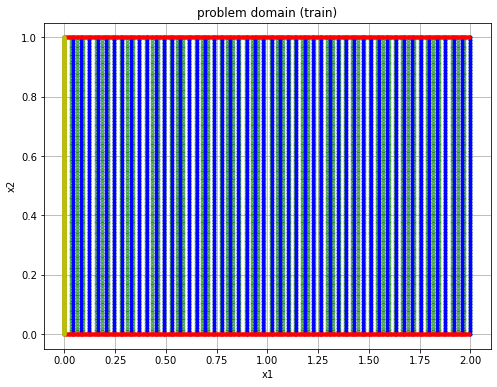

In [38]:
data = np.load('data/data.npz',allow_pickle=True)
x_pde = data['x_pde']
x_bd = data['x_bd']
x_ic = data['x_ic']

x_test = data['x_test']

target_pde = data['target_pde']
target_bd = data['target_bd'].item()['u']
target_ic = data['target_ic'].item()['u']
target_ic0 = data['target_ic'].item()['u0']

target_test = data['target_test'].item()['u']


plot_domain_2d(x_pde=x_pde, x_bd=x_bd, x_test=x_test, x_ic=x_ic)


In [39]:
x_pde = torch.from_numpy(x_pde).float()
x_bd = torch.from_numpy(x_bd).float()
x_ic = torch.from_numpy(x_ic).float()
x_test = torch.from_numpy(x_test).float()

target_pde = torch.from_numpy(target_pde).float()
target_bd = torch.from_numpy(target_bd).float()
target_ic = torch.from_numpy(target_ic).float()
target_ic0 = torch.from_numpy(target_ic0).float()
target_test = torch.from_numpy(target_test).float()

print(x_pde.shape, target_pde.shape)
print(x_bd.shape, target_bd.shape)
print(x_ic.shape, target_ic.shape, target_ic0.shape)
print(x_test.shape, target_test.shape)


torch.Size([5000, 2]) torch.Size([5000, 1])
torch.Size([996, 2]) torch.Size([996, 1])
torch.Size([502, 2]) torch.Size([502, 1]) torch.Size([502, 1])
torch.Size([7326, 2]) torch.Size([7326, 1])


In [40]:
def train_Adam(model, optimizer_Adam, lr_scheduler):
    optimizer_Adam.zero_grad()
    op_pde = pde(x_pde, model)
    loss_pde = criterion(op_pde, target_pde)

    u_bd = model(x_bd)
    loss_bd = criterion(u_bd, target_bd)

    u_ic, ut_ic = uu_t(x_ic, model)
    loss_ic = criterion(u_ic, target_ic)
    loss_ic0 = criterion(ut_ic, target_ic0)

    loss = loss_pde + loss_bd + loss_ic + loss_ic0

    loss.backward()

    optimizer_Adam.step()
    lr_scheduler.step()
    return loss.item(), loss_pde.item(), loss_bd.item()


def train_LBFGS(model, optimizer_LBFGS):

    def closure():
        if torch.is_grad_enabled():
            optimizer_LBFGS.zero_grad()

        op_pde = pde(x_pde, model)
        loss_pde = criterion(op_pde, target_pde)

        u_bd = model(x_bd)
        loss_bd = criterion(u_bd, target_bd)

        u_ic, ut_ic = uu_t(x_ic, model)
        loss_ic = criterion(u_ic, target_ic)
        loss_ic0 = criterion(ut_ic, target_ic0)

        loss = loss_pde + loss_bd + loss_ic + loss_ic0

        if loss.requires_grad:
            loss.backward()
        return loss

    optimizer_LBFGS.step(closure)
    loss = closure()

    return loss.item()



In [41]:
criterion = nn.MSELoss()
epochs_Adam = 5000
epochs_LBFGS = 201
lr = 0.001
gamma = 0.7
step_size = 2000


# model  = FCNet(input_dim=2, output_dim=1, width=500, hidden=1)
# optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)
#
# optimizer_LBFGS = optim.LBFGS(model.parameters(),
#                                    max_iter=20,
#                                    tolerance_grad=1.e-8,
#                                    tolerance_change=1.e-12)
use_cuda = True
if use_cuda:
    x_pde = x_pde.cuda()
    x_bd = x_bd.cuda()
    x_test = x_test.cuda()
    x_ic = x_ic.cuda()

    target_pde = target_pde.cuda()
    target_bd = target_bd.cuda()
    target_ic0 = target_ic0.cuda()
    target_ic = target_ic.cuda()

    target_test = target_test.cuda()


In [42]:

def train(width):
    model  = FCNet(input_dim=2, output_dim=1, width=width, hidden=1)
    optimizer_Adam = optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = StepLR(optimizer_Adam,step_size=step_size,gamma=gamma)

    optimizer_LBFGS = optim.LBFGS(model.parameters(),
                                       max_iter=20,
                                       tolerance_grad=1.e-8,
                                       tolerance_change=1.e-12)
    if use_cuda:
        model.cuda()


    record_epoch = []
    train_loss = []
    test_mse = []
    for epoch in range(epochs_Adam):
        loss, loss1, loss2 = train_Adam(model,optimizer_Adam,lr_scheduler)
        if epoch % 100 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())

    for epoch in range(epochs_Adam, epochs_Adam + epochs_LBFGS):
        loss = train_LBFGS(model,optimizer_LBFGS)
        if epoch % 20 == 0:
            print(epoch, loss)
            record_epoch.append(epoch)
            train_loss.append(loss)
            test_mse.append(criterion(target_test, model(x_test)).item())
    return record_epoch, train_loss, test_mse

In [43]:
width_vec = [100,250,500,750,1000]
result_all = []
for width in width_vec:
    print(width,'.....................')
    record_epoch, train_loss, test_mse = train(width)
    result_all.append([record_epoch, train_loss, test_mse])

100 .....................
0 0.712897777557373
100 0.4702865481376648
200 0.465159147977829
300 0.46357423067092896
400 0.46316251158714294
500 0.4629097282886505
600 0.46271029114723206
700 0.4625530540943146
800 0.46242934465408325
900 0.46233129501342773
1000 0.46225258708000183
1100 0.46218836307525635
1200 0.46213486790657043
1300 0.46208876371383667
1400 0.4620470106601715
1500 0.46200692653656006
1600 0.4619661867618561
1700 0.46192285418510437
1800 0.4618748724460602
1900 0.4618190824985504
2000 0.4617515206336975
2100 0.4616944491863251
2200 0.46162745356559753
2300 0.46154922246932983
2400 0.46145856380462646
2500 0.46135464310646057
2600 0.4612366855144501
2700 0.4611033797264099
2800 0.4609518051147461
2900 0.46077531576156616
3000 0.46055886149406433
3100 0.460269033908844
3200 0.45982998609542847
3300 0.4590489864349365
3400 0.4572966694831848
3500 0.45374995470046997
3600 0.44739222526550293
3700 0.4380137026309967
3800 0.4289344549179077
3900 0.4192701578140259
4000 0.40

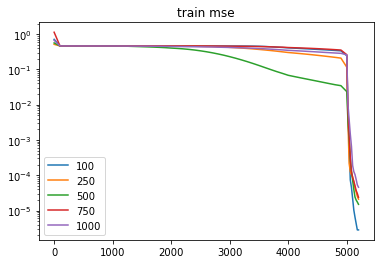

In [44]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][1], label=width_vec[i])
plt.yscale('log')
plt.title('train mse')
plt.legend()
plt.show()

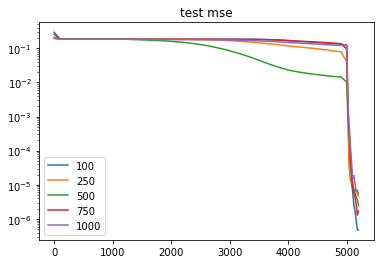

In [48]:
for i in range(len(width_vec)):
    plt.plot(result_all[i][0], result_all[i][2], label=width_vec[i])
plt.yscale('log')
plt.title('test mse')
plt.legend()
plt.show()

In [49]:
result_all = np.array(result_all)
np.save('pinn_raw',result_all)

In [50]:
final_mse = []
final_mse_adam = []
for i in range(len(width_vec)):
    index = result_all[i][0]
    temp = np.array(result_all[i][2])
    final_mse.append(temp.min())
    final_mse_adam.append(temp[index==epochs_Adam].item())

df = pd.DataFrame({'basis_num': width_vec, 'mse_final': final_mse, 'mse_adam': final_mse_adam})
df.to_csv(f'pinn.csv',header=True, index=False, encoding='utf-8')